# 작업 공간 다운로드

In [1]:
# current_file_name = 'backtesting-pykrx_phj'

# import dill
# import os
# # and to load the session again:
# try:
#     dill.load_session(os.getcwd() +'/'+current_file_name + '.pkl')
# except:
#     print('Please check if the pkl file exists')

# 기본 패키지, 모듈 삽입

In [2]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

### 참고 링크
* [참고 영상: Backtesting.py SMA Crossover Strategy Example with Bitcoin: Using Python to Optimize Parameters](https://youtu.be/gdrSo1Yclys)  
* [PyKrx](https://github.com/sharebook-kr/pykrx)

## 코스닥 종목 탐색

In [3]:
duration = "20180101", "20211231"
rolling_period = 10

# 해당 기간에 존재하는 종목번호만 추출&적용
kos_set0 = set(stock.get_market_ticker_list(duration[0], market="KOSDAQ"))
kos_set1 = set(stock.get_market_ticker_list(duration[1], market="KOSDAQ"))
kos_list = list(kos_set0 & kos_set1)

df = stock.get_market_cap(duration[1])
df = df.loc[kos_list]

# 티커 to 종목명
name_list =[]
for idx in df.index:
    name_list.append(stock.get_market_ticker_name(idx))

df['종목명'] = name_list
df.sort_values(by = '종목명',inplace=True)
df = df[['종목명','종가',	'시가총액',	'거래량',	'거래대금',	'상장주식수']]
df.to_csv(duration[0]+'~'+ duration[1]+'_stock_df.csv',encoding='utf-8')

# 필요한 코스닥 종목 df 완성
df

,종목명,종가,시가총액,거래량,거래대금,상장주식수
티커,,,,,,
060310,3S,3300,152695992900,114207,377653515,46271513
054620,APS홀딩스,14000,285519094000,275806,3839060350,20394221
265520,AP시스템,25150,384327738150,123779,3088746800,15281421
211270,AP위성,14850,223972214400,385166,5687664800,15082304
032790,BNGT,4075,120352455875,0,0,29534345
...,...,...,...,...,...,...
024060,흥구석유,7150,107250000000,192620,1376777280,15000000
010240,흥국,8050,99197702800,414148,3415429690,12322696
189980,흥국에프엔비,3820,152791485220,430847,1647544075,39997771


In [4]:
## 코스닥 종목 리스트 생성

# kos_target_list = ['91990','263750','66970','112040','68760','28300','96530','196170','35760','58470','253450','108320','86520','237690','5290','67160','240810','48260','78340','140410','145020','25900','35900','64760','41510','98460','32500','78600','144510','39030','222800','95700','256840','63080','213420','141080','34230','56190','36540']
kos_target_list = ['63170','218410','73490','278280']
kos_target_list = list(set(kos_target_list) & set(kos_list))
print(kos_target_list)

kos_target = '218410'

['218410']


## 코스닥 지수 다운로드

In [5]:
kq11_df = stock.get_index_ohlcv(duration[0], duration[1], "2001")
kq11_df.drop('거래대금',axis=1,inplace=True)
kq11_df.columns = ['Open', 'High', 'Low', 'Close','Volume']
kq11_df_close = kq11_df['Close']
kq11_df_close_vari = (kq11_df_close.rolling(rolling_period).min() - kq11_df_close.rolling(rolling_period).max() )/kq11_df_close.rolling(rolling_period).max() 
kq11_df_close_vari.fillna(method = 'backfill',inplace=True)
# kq11_df_close_vari.dropna(axis=0,inplace=True)
# kq11_df_close_vari = kq11_df_close_vari[kq11_df_close_vari<= -10]

Text(0.5, 1.0, '코스닥')

C:\ProgramData\Anaconda3\envs\pystock\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


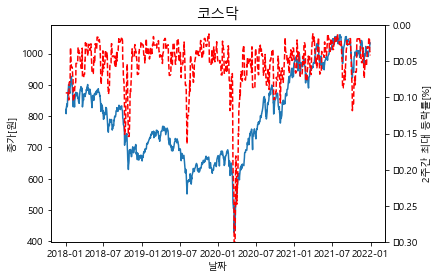

In [6]:
folder_name = 'energy_data\processed_data\smgw//'
folder_name_fig = 'energy_data//fig\smgw//'
font_path = 'C:\Windows\Fonts//gulim.ttc'
font = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 12
matplotlib.rc('font', family=font)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
fig.set_facecolor('white') ## 캔버스 색상 설정
    
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 12
matplotlib.rc('font', family=font)

x = kq11_df_close.index
y = kq11_df_close

ax1.set_xlabel('날짜')
ax1.set_ylabel('종가[원]')
ax1.plot(x, y,'-')

x2 = kq11_df_close_vari.index
y2 = kq11_df_close_vari

ax2.set_ylabel('2주간 최대 등락률[%]')
ax2.plot(x2, y2,'--',color='red')
ax2.set_ylim([-0.30,0])
# ax2.set_ylim([0,30])

plt.title('코스닥')

# 코스닥 종목 분석

#### 함수 생성

In [7]:
class SmaCross(Strategy):
    n = 10
    p = 0.025
    index_limit = -0.07
    num_order = 0
    upper = 0

    def init(self):
        print(f'len(data)={len(self.data)}')
        #self.ma = self.data.df['Close'].rolling(self.n).mean().fillna(method = 'backfill')
        #import pandas as pd
        close = self.data['Close']
        self.sma1 = self.I(SMA, close, self.n)
        self.sma2 = self.sma1 
        # self.data['Upper'] = pd.DataFrame(self.data['Close']).rolling(self.n).mean() * (1 + self.p) 

    def next(self):
        if self.data['KOSDAQ'][-1] < self.index_limit:
            if self.num_order < 1:
                self.buy()
                self.num_order += 1
            # else:
                # print('order prohibite')
        # elif crossover(self.sma2, self.sma1):
        elif self.data['Close'][-1] >= self.sma1[-1] * (1+self.p) :
            self.position.close()
            if self.num_order > 0:
                self.num_order -= 1
            # self.sell()

# MA 함수
def ma(Data, lookback, what, where):
    for i in range(len(Data)):
        try:
            Data[i, where] = (Data[i - lookback + 1:i + 1, what].mean())
        except IndexError:
            pass
    return Data

# Data np.arry에 새로운 빈 컬럼 추가 함수
def adder(Data, times=1):
    for i in range(1, times + 1):
        z = np.zeros((len(Data), 1), dtype = float)
        Data = np.append(Data, z, axis = 1)
    return Data

# Envelopes 지표 생성
## 사용 예:
# Calling the function on the closing price (index = 3) 
## my_data = envelopes(my_data, 10, 0.0025, 3, 4) #  deviation of 0.25%
def envelopes(Data, lookback, deviation, what=4, where=5):
    # Calculating the moving average
    Data = ma(Data, lookback, what, where)
    # Upper Envelope
    try:
        Data[:, where + 1] = Data[:, where] + (Data[:, where] * deviation)
    except:
        Data = adder(Data)
        Data[:, where + 1] = Data[:, where] + (Data[:, where] * deviation)
    # Lower Envelope     
    try:  
        Data[:, where + 2] = Data[:, where] - (Data[:, where] * deviation)
    except:
        Data = adder(Data)
        Data[:, where + 2] = Data[:, where] + (Data[:, where] * deviation)
    return Data

In [8]:
kos_target

'218410'

In [10]:
kos_target_df = stock.get_market_ohlcv(duration[0], duration[1],kos_target)
kos_target_df.rename(columns={
'시가': 'Open',
'고가': 'High',
'저가': 'Low',
'종가': 'Close',
'거래량': 'Volume'
}, inplace=True)
kos_target_df['KOSDAQ'] = kq11_df_close_vari
kos_target_df['Rolling'] = kos_target_df['Close'].rolling(10).mean().fillna(method = 'backfill')

In [11]:
kos_target_df

,Open,High,Low,Close,Volume,KOSDAQ,Rolling
날짜,,,,,,,
2018-01-02,16732,16732,15610,15806,379522,-0.093763,16747.5
2018-01-03,16098,16342,15415,15660,415187,-0.093763,16747.5
2018-01-04,16293,16586,15805,16196,418951,-0.093763,16747.5
2018-01-05,16293,16879,15903,16684,243027,-0.093763,16747.5
2018-01-08,17025,18147,16976,17855,772143,-0.093763,16747.5
...,...,...,...,...,...,...,...
2021-12-24,32850,33100,32500,32800,142915,-0.017215,33890.0
2021-12-27,33100,33450,32700,32800,152659,-0.020616,33665.0
2021-12-28,34000,35800,33700,35650,728693,-0.035944,33695.0


In [12]:
kos_target_df['Close']

날짜
2018-01-02    15806
2018-01-03    15660
2018-01-04    16196
2018-01-05    16684
2018-01-08    17855
              ...  
2021-12-24    32800
2021-12-27    32800
2021-12-28    35650
2021-12-29    34700
2021-12-30    35650
Name: Close, Length: 986, dtype: int32

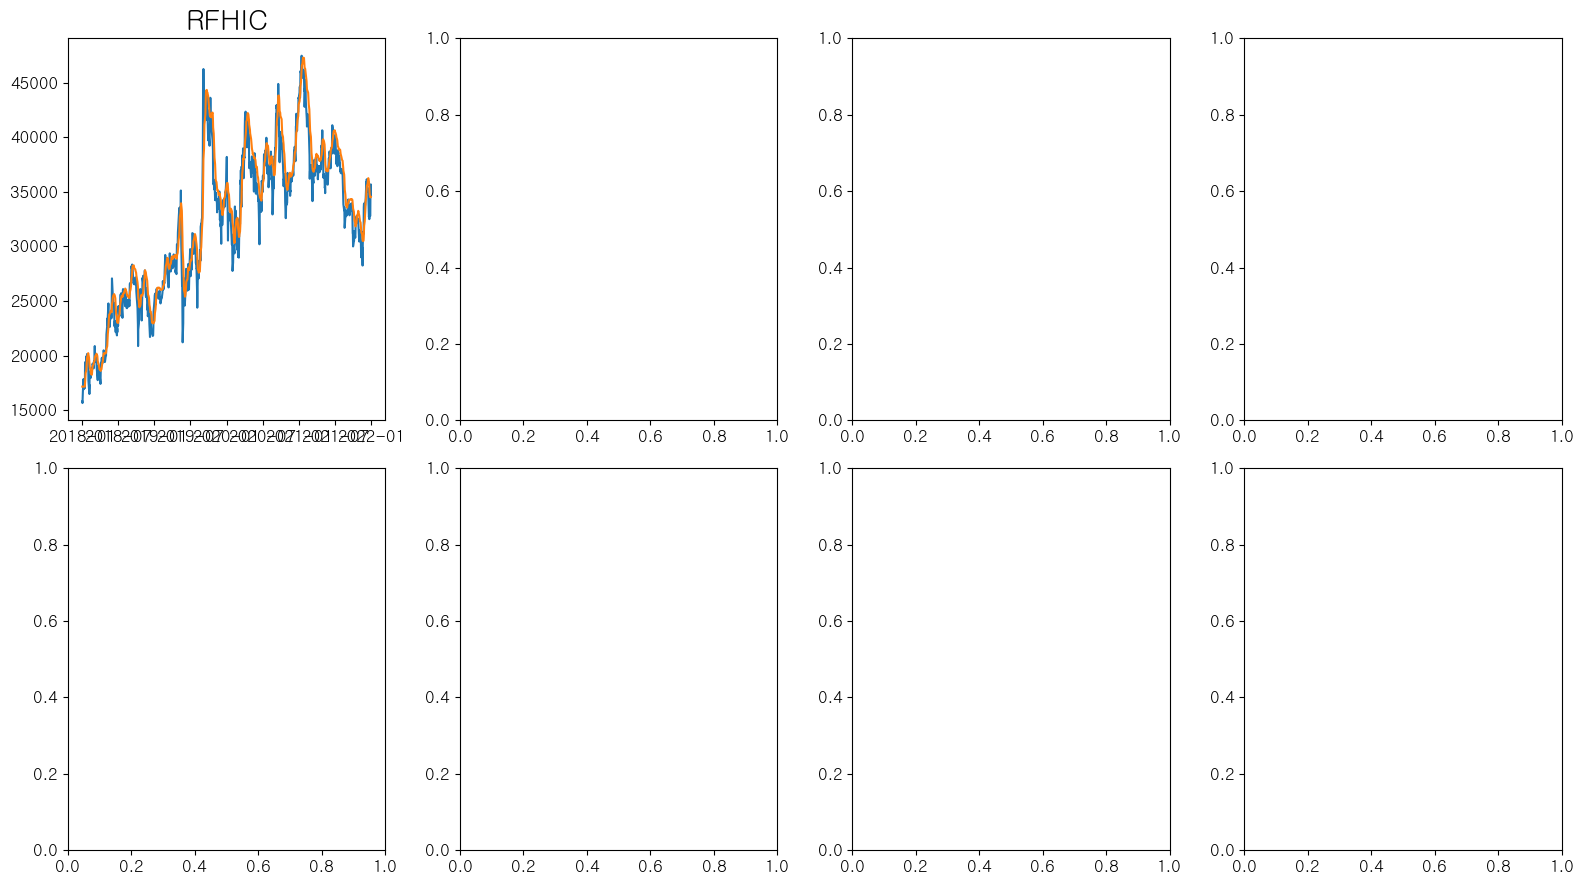

In [13]:
fig, axes = plt.subplots(len(kos_target_list)//4+2,4, figsize=(16, 9))

# fig.suptitle('mean values per wear_rate', fontsize= 40)
for i, tic in enumerate(kos_target_list):
    row = i//4
    col = i%4
    ax = axes[row,col]
    ax.plot(kos_target_df.index,kos_target_df['Close'])
    ax.plot(kos_target_df.index,kos_target_df['Rolling']*(1 + 0.025))
    ax.set_title(df['종목명'].loc[tic], fontsize=20)
    
plt.tight_layout()
plt.show()

In [14]:

kos_target_result= Backtest(kos_target_df, SmaCross,
        cash=10000000, commission=.0023,
        exclusive_orders=True)
kos_target_output = kos_target_result.run()

len(data)=986


In [15]:
kos_target_output

Start                     2018-01-02 00:00:00
End                       2021-12-30 00:00:00
Duration                   1458 days 00:00:00
Exposure Time [%]                   30.831643
Equity Final [$]                24748649.7657
Equity Peak [$]                   28226493.21
Return [%]                         147.486498
Buy & Hold Return [%]              125.547261
Return (Ann.) [%]                   26.061696
Volatility (Ann.) [%]               36.585505
Sharpe Ratio                          0.71235
Sortino Ratio                        1.497705
Calmar Ratio                         0.876805
Max. Drawdown [%]                   -29.72349
Avg. Drawdown [%]                   -5.838866
Max. Drawdown Duration      458 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                   21
Win Rate [%]                        76.190476
Best Trade [%]                      17.955502
Worst Trade [%]                    -10.593149
Avg. Trade [%]                    

In [16]:
kos_target_output['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,504,11,17,19802.4411,19708,-4.759831e+04,-0.004769,2018-01-17,2018-01-25,8 days
1,607,25,34,16379.5866,19171,1.694388e+06,0.170420,2018-02-06,2018-02-21,15 days
2,630,56,66,18482.4120,19123,4.035704e+05,0.034659,2018-03-26,2018-04-09,14 days
3,550,113,121,21905.2665,23367,8.039534e+05,0.066730,2018-06-20,2018-07-02,12 days
4,546,137,144,23517.9672,25855,1.276020e+06,0.099372,2018-07-24,2018-08-02,9 days
5,570,186,197,24789.8859,25562,4.401050e+05,0.031146,2018-10-08,2018-10-24,16 days
6,573,199,213,25425.3441,27757,1.336039e+06,0.091706,2018-10-26,2018-11-15,20 days
7,539,372,373,29483.6568,30050,3.052590e+05,0.019209,2019-07-10,2019-07-11,1 days
8,561,386,404,28897.3113,31416,1.412984e+06,0.087160,2019-07-30,2019-08-26,27 days
9,394,412,416,44690.5524,42344,-9.245416e+05,-0.052507,2019-09-05,2019-09-11,6 days


In [17]:
kos_target_result.plot()

Row(id='1428', ...)

In [18]:
index_range=-1*np.array([0.07,0.08,0.09,0.10,0.12,0.15])

In [19]:
stats, heatmap = kos_target_result.optimize(index_limit= list(index_range), n=range(3, 30, 1), p=[0.01,0.015,0.02,0.025,0.030,0.035,0.04,0.05,0.06,0.07,0.08,0.09,0.10], 
    maximize='Equity Final [$]',
    constraint=lambda param: True, return_heatmap=True
    )
print(f'stats={stats}')
print(f'stats._strategy={stats._strategy}')
kos_target_result.plot()
plt.show()


C:\ProgramData\Anaconda3\envs\pystock\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 2106 configurations.
  output = _optimize_grid()


len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(data)=986
len(da

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

heatmap=n1  n2 
50  70     13729150.75
60  175    13729150.75
    145    13729150.75
    150    13729150.75
    155    13729150.75
    160    13729150.75
    165    13729150.75
    170    13729150.75
    180    13729150.75
65  95     13729150.75
Name: Equity Final [$], dtype: float64


<AxesSubplot:xlabel='n2', ylabel='n1'>

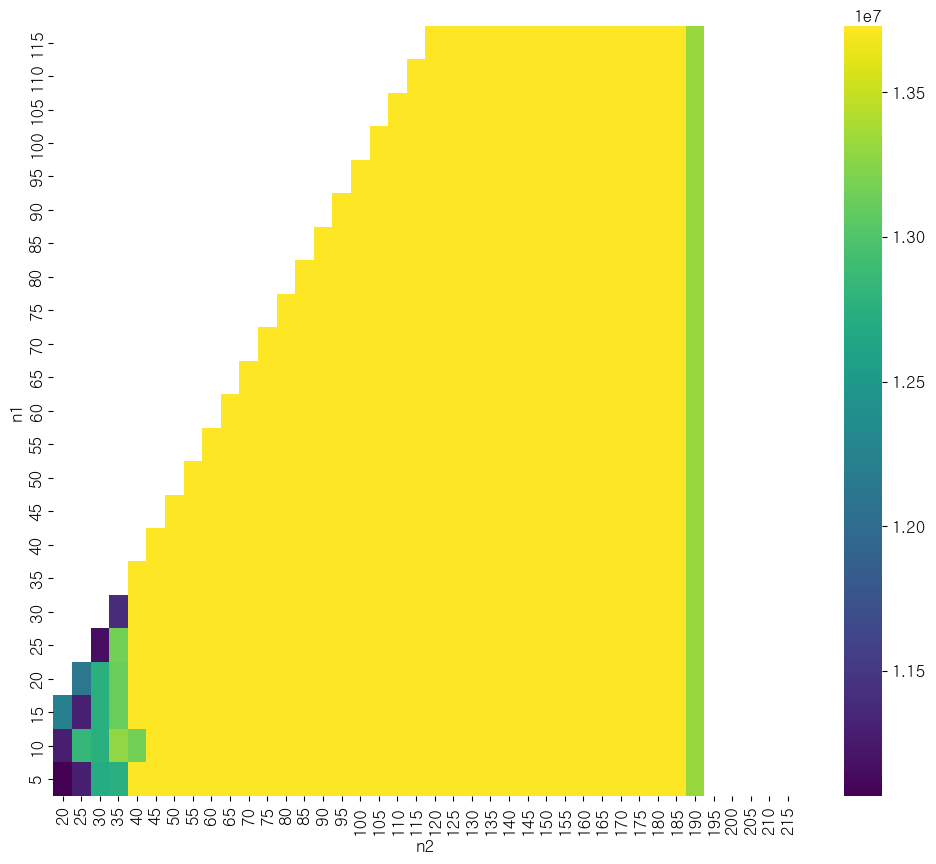

In [ ]:
print(f'heatmap={heatmap.sort_values(ascending=False).iloc[:10]}')
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')
# plt.savefig('sma-crossover-heapmap.png')

In [20]:
## 작업 공간 저장(마지막에 배치)

try:
    dill.dump_session(os.getcwd() +'/'+current_file_name + '.pkl')
except:
    print('can not save the data')

NameError: name 'dill' is not defined